<a href="https://colab.research.google.com/github/sheelapravalika/sheela2000.drdo/blob/main/DF_noise_level%3D0_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading dataset...


Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:28:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Fusion Accuracy with Train & Test Label Noise: 0.9688

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      3650
           1       0.98      0.66      0.79       350

    accuracy                           0.97      4000
   macro avg       0.97      0.83      0.88      4000
weighted avg       0.97      0.97      0.97      4000



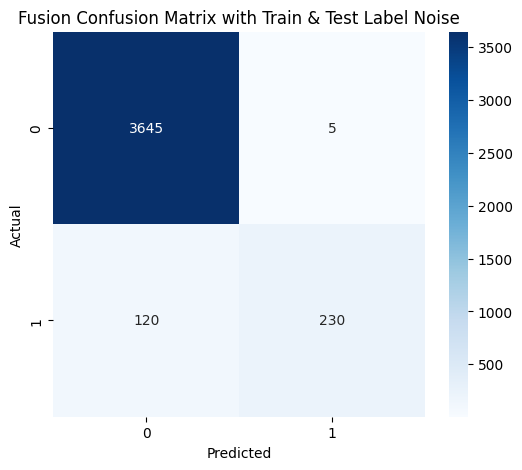

In [ ]:
# ✅ STEP 1: Install Required Packages
!pip install -q datasets sentence-transformers xgboost

# ✅ STEP 2: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import random

from datasets import load_dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
from scipy.stats import mode

# ✅ STEP 3: Load 20K Samples from Dataset
print("Loading dataset...")
dataset = load_dataset("sonnh-tech1/cic-ids-2017", "binary", split="train[:20000]")
df = dataset.to_pandas()
df.dropna(inplace=True)

# ✅ STEP 4: Prepare Features
numeric_df = df.select_dtypes(include=[np.number])
if 'Label' not in numeric_df.columns and 'Label' in df.columns:
    numeric_df['Label'] = df['Label']

X = numeric_df.drop(columns=['Label'], errors='ignore')
y = LabelEncoder().fit_transform(numeric_df['Label'])

# ✅ STEP 5: Scale Data and Embed for SLM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
text_data = pd.DataFrame(X_scaled).astype(str).agg(' '.join, axis=1).tolist()

model_slm = SentenceTransformer('paraphrase-MiniLM-L3-v2')
X_embed = model_slm.encode(text_data, batch_size=16, convert_to_numpy=True, show_progress_bar=True)

# ✅ STEP 6: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_embed, y, test_size=0.2, stratify=y, random_state=42)

# ✅ STEP 7: Add Label Noise for Training and Test
def flip_training_labels(y, noise_level=0.02):
    y_noisy = y.copy()
    n = len(y)
    flip_count = int(noise_level * n)
    indices = np.random.choice(n, flip_count, replace=False)
    for i in indices:
        y_noisy[i] = 1 - y_noisy[i]
    return y_noisy

# Add noise to training and test labels
y_train_noisy = flip_training_labels(y_train, noise_level=0.02)
y_train_s_noisy = flip_training_labels(y_train_s, noise_level=0.02)
y_test_noisy = flip_training_labels(y_test, noise_level=0.02)

# ✅ STEP 8: Train All Models (Weakened)
rf = RandomForestClassifier(n_estimators=5, max_depth=2, min_samples_leaf=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train_noisy)

ann = MLPClassifier(hidden_layer_sizes=(4,), max_iter=10, solver='adam', random_state=42)
ann.fit(X_train, y_train_noisy)

gb = XGBClassifier(n_estimators=2, max_depth=1, learning_rate=0.01, use_label_encoder=False, eval_metric='logloss', random_state=42)
gb.fit(X_train, y_train_noisy)

slm = LogisticRegression(max_iter=50, class_weight='balanced', C=0.01)
slm.fit(X_train_s, y_train_s_noisy)

# ✅ STEP 9: Predict and Fuse
rf_pred = rf.predict(X_test)
ann_pred = ann.predict(X_test)
gb_pred = gb.predict(X_test)
slm_pred = slm.predict(X_test_s)

all_preds = np.vstack([rf_pred, ann_pred, gb_pred, slm_pred])
fusion_pred, _ = mode(all_preds, axis=0)
fusion_pred = fusion_pred.flatten()

# ✅ STEP 10: Evaluate on Noisy Test Labels
acc = accuracy_score(y_test_noisy, fusion_pred)
print(f"\n✅ Fusion Accuracy with Train & Test Label Noise: {acc:.4f}")
print("\n✅ Classification Report:\n", classification_report(y_test_noisy, fusion_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_noisy, fusion_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Fusion Confusion Matrix with Train & Test Label Noise")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
